## Optimizers from Scratch

For implementing different optimizers a Model class has to be created

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
# Creating labels and values
def generate_values(x1, x2, x3):
    return (x3**3 * 0.8) + (x2**2 * 0.1) + (x1 * 0.5) + 4.

In [3]:
x = torch.tensor([[0.7, 0.3, 0.7],
                  [0.4, 1., 0.4],
                  [1.2, 1.8, 0.9],
                  [0.6, 0.2, 1.5],
                  [0.1, 2.2, 0.6]])
y = torch.tensor([generate_values(i[0], i[1], i[2]) for i in x])
print(x.shape, y.shape)
print(y)

torch.Size([5, 3]) torch.Size([5])
tensor([4.6334, 4.3512, 5.5072, 7.0040, 4.7068])


In [4]:
class Model:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
        self._init_params()
        self._init_momentum()
        self._init_RMSs()
    
    def _init_params(self):
        self.weights1 = self._random_tensor((x.shape[1], 3))
        self.bias1 = self._random_tensor(1)
        self.weights2 = self._random_tensor((3, 1))
        self.bias2 = self._random_tensor(1)
        
    def _random_tensor(self, size): return (torch.randn(size)).requires_grad_()
    
    def _init_momentum(self):
        self.mom_w1, self.mom_b1 = [0], [0] # weights and bias
        self.mom_w2, self.mom_b2 = [0], [0]
    
    def _init_RMSs(self):
        self.RMSs_w1, self.RMSs_b1 = [0], [0]
        self.RMSs_w2, self.RMSs_b2 = [0], [0]
    
    def _nn(self, xb):
        l1 = xb @ self.weights1 + self.bias1 # W.X + b
        l2 = l1.max(torch.tensor(0.0))
        l3 = l2 @ self.weights2 + self.bias2
        return l3
    
    def _loss_fn(self, preds, yb):
        return ((preds-yb)**2).mean()
    
    def train(self, optim):
        # Different Learning rates to compare
        lrs = [10e-4, 10e-3, 10e-2, 10e-1]
        # For plotting
        fig, axs = plt.subplots(2, 2)
        all_losses = []
        for i, lr in enumerate(lrs):
            losses = []
            while(len(losses) == 0 or losses[-1] > 0.1 and len(losses) < 1000):
                preds = self._nn(self.x)
                loss = self._loss_fn(preds, self.y)
                loss.backward()
                
                optim(self.weights1, lr, self.mom_w1, self.RMSs_w1)
                optim(self.bias1, lr, self.mom_b1, self.RMSs_b1)
                optim(self.weights2, lr, self.mom_w2, self.RMSs_w2)
                optim(self.bias2, lr, self.mom_b2, self.RMSs_b2)
                
                losses.append(loss.item())
            all_losses.append(losses)
            
            # Plot
            xi = i % 2
            yi = int(i/2)
            axs[xi, yi].plot(list(range(len(losses))), losses)
            axs[xi, yi].set_ylim(0, 30)
            axs[xi, yi].set_title('Learning Rate:'+str(lr))
            
            # Set Seed value for better comparision (params are init in a same way)
            torch.random.seed()
            self._init_params()
            self._init_momentum()
            self._init_RMSs()
        
        for ax in axs.flat:
            ax.set(xlabel='steps', ylabel='loss (MSE)')
        plt.tight_layout()

In [5]:
model = Model(x, y)

## SGD Optimizer
Stochastic gradient descent (SGD) in contrast performs a parameter update for each training example 
x(i) and label y(i)


<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>&#x03B8;<!-- θ --></mi>
  <mo>=</mo>
  <mi>&#x03B8;<!-- θ --></mi>
  <mo>&#x2212;<!-- − --></mo>
  <mi>&#x03B7;<!-- η --></mi>
  <mo>&#x22C5;<!-- ⋅ --></mo>
  <msub>
    <mi mathvariant="normal">&#x2207;<!-- ∇ --></mi>
    <mi>&#x03B8;<!-- θ --></mi>
  </msub>
  <mi>J</mi>
  <mo stretchy="false">(</mo>
  <mi>&#x03B8;<!-- θ --></mi>
  <mo>;</mo>
  <msup>
    <mi>x</mi>
    <mrow class="MJX-TeXAtom-ORD">
      <mo stretchy="false">(</mo>
      <mi>i</mi>
      <mo stretchy="false">)</mo>
    </mrow>
  </msup>
  <mo>;</mo>
  <msup>
    <mi>y</mi>
    <mrow class="MJX-TeXAtom-ORD">
      <mo stretchy="false">(</mo>
      <mi>i</mi>
      <mo stretchy="false">)</mo>
    </mrow>
  </msup>
  <mo stretchy="false">)</mo>
</math>

In [6]:
# Using SGD (Stochastic gradient descent)
def SGD(a, lr, _, __):
    a.data -= a.grad * lr
    a.grad = None

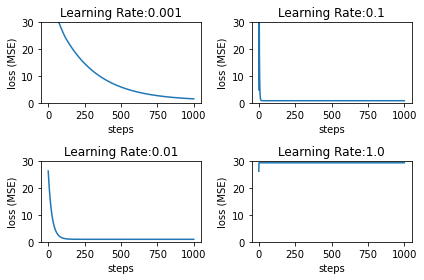

In [7]:
model.train(SGD)

## Momentum
SGD there is a problem that steps continue to be small even though the model might be pretty sure that the direction is right. Momentum takes bigger and bigger steps the more sure it is about the direction.

It does this by adding a fraction 
γ of the update vector of the past time step to the current update vector:

<b>SGD without Momentum</b>
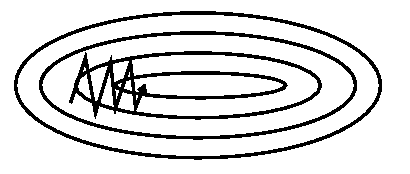

<b>SGD with Momentum</b>
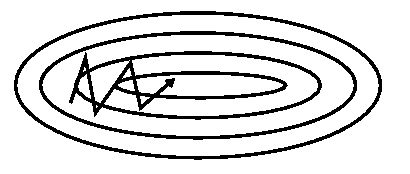    

\begin{align} 
\begin{split} 
v_t &= \gamma v_{t-1} + \eta \nabla_\theta J( \theta) \\ 
\theta &= \theta - v_t 
\end{split} 
\end{align}

In momentum optimizer we need to first calculate momentum. It's gradient times small value (almost always 0.1) multiplied by previous momentum times 1-the_small_value. This way it mostly goes to the same direction where it was going the last time but gradient still can change the direction.

In [12]:
def momentum(a,_, moms, __): # 4 are initialized in the Model Class so..
    prev_mometum = moms[-1]
    
    mom = a.grad * 0.1 + prev_mometum * 0.9
    moms.append(mom)
    a.data -= mom
    a.grad = None

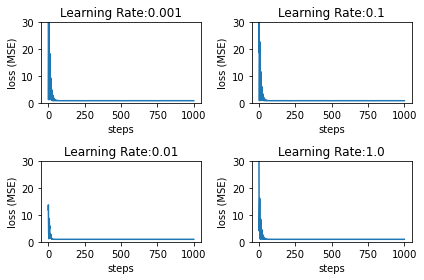

In [13]:
model.train(momentum)

## RMSprop

RMSprop is the same as momentum except gradient is squared.

Because the gradient is squared it means that if the gradient is:
* small RMSprop becomes small
* volatile RMSprop becomes big
* big RMSprop becomes big

Then parameteres are updated by multiplying the gradient with learning rate and then dividing it with square root of RMSprop. This means that if RMSprop is small the parameters are updated more.


RMSprop and Adadelta have both been developed independently around the same time stemming from the need to resolve Adagrad's radically diminishing learning rates.

\begin{align} 
\begin{split} 
E[g^2]_t &= 0.9 E[g^2]_{t-1} + 0.1 g^2_t \\ 
\theta_{t+1} &= \theta_{t} - \dfrac{\eta}{\sqrt{E[g^2]_t + \epsilon}} g_{t} 
\end{split} 
\end{align}

In [14]:
def RMSprop(a, lr, _, RMSs):
    prev_RMS = RMSs[-1]
    
    RMS = (a.grad ** 2 * 0.1 + prev_RMS * 0.9)
    RMSs.append(RMS)
    
    # Gamma is added to make sure there is never divide with zero
    gamma = 1e-5
    a.data -= (a.grad * lr) / (torch.sqrt(RMS) + gamma)
    a.grad = None

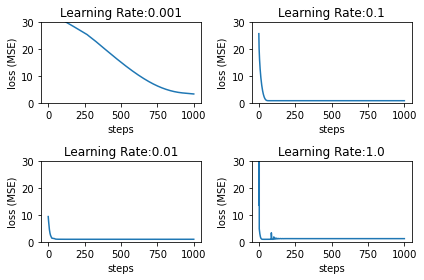

In [15]:
model.train(RMSprop)

## Adam 
Adaptive Moment Estimation (Adam) is another method that computes adaptive learning rates for each parameter.
In addition to storing an exponentially decaying average of past squared gradients<math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
    <mi>v</mi>
    <mi>t</mi>
  </msub>
</math> like Adadelta and RMSprop, Adam also keeps an exponentially decaying average of past gradients 
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
    <mi>m</mi>
    <mi>t</mi>
  </msub>
</math>, similar to momentum.

Whereas momentum can be seen as a ball running down a slope, Adam behaves like a heavy ball with friction, which thus prefers flat minima in the error surface.

We compute the decaying averages of past and past squared gradients m_t and v_t respectively as follows:

\begin{align} 
\begin{split} 
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t \\ 
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 
\end{split} 
\end{align}

m_t and v_t are estimates of the first moment (the mean) and the second moment (the uncentered variance) of the gradients respectively, hence the name of the method.

As. <math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
    <mi>m</mi>
    <mi>t</mi>
  </msub>
</math> and <math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
    <mi>v</mi>
    <mi>t</mi>
  </msub>
</math>
are initialized as vectors of 0's, the authors of Adam observe that they are biased towards zero, especially during the initial time steps, and especially when the decay rates are small <math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
    <mi>&#x03B2;<!-- β --></mi>
    <mn>1</mn>
  </msub>
</math> and <math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
    <mi>&#x03B2;<!-- β --></mi>
    <mn>2</mn>
  </msub>
</math> are close to 1

They counteract these biases by computing bias-corrected first and second moment estimates:

\begin{align} 
\begin{split} 
\hat{m}_t &= \dfrac{m_t}{1 - \beta^t_1} \\ 
\hat{v}_t &= \dfrac{v_t}{1 - \beta^t_2} \end{split} 
\end{align}

They then use these to update the parameters just as we have seen in Adadelta and RMSprop, which yields the Adam update rule:

<math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
    <mi>&#x03B8;<!-- θ --></mi>
    <mrow class="MJX-TeXAtom-ORD">
      <mi>t</mi>
      <mo>+</mo>
      <mn>1</mn>
    </mrow>
  </msub>
  <mo>=</mo>
  <msub>
    <mi>&#x03B8;<!-- θ --></mi>
    <mrow class="MJX-TeXAtom-ORD">
      <mi>t</mi>
    </mrow>
  </msub>
  <mo>&#x2212;<!-- − --></mo>
  <mstyle displaystyle="true" scriptlevel="0">
    <mfrac>
      <mi>&#x03B7;<!-- η --></mi>
      <mrow>
        <msqrt>
          <msub>
            <mrow class="MJX-TeXAtom-ORD">
              <mover>
                <mi>v</mi>
                <mo stretchy="false">&#x005E;<!-- ^ --></mo>
              </mover>
            </mrow>
            <mi>t</mi>
          </msub>
        </msqrt>
        <mo>+</mo>
        <mi>&#x03F5;<!-- ϵ --></mi>
      </mrow>
    </mfrac>
  </mstyle>
  <msub>
    <mrow class="MJX-TeXAtom-ORD">
      <mover>
        <mi>m</mi>
        <mo stretchy="false">&#x005E;<!-- ^ --></mo>
      </mover>
    </mrow>
    <mi>t</mi>
  </msub>
</math>


The authors propose default values of 0.9 for 
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
    <mi>&#x03B2;<!-- β --></mi>
    <mn>1</mn>
  </msub>
</math>
, 0.999 for 
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
    <mi>&#x03B2;<!-- β --></mi>
    <mn>2</mn>
  </msub>
</math>
, and 
10
−
8
 for 
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>&#x03F5;<!-- ϵ --></mi>
</math>

<b>In Simple Words</b> 

Adam is simply combination of RMSprop and momentum. That's it. Nothing more. Adam is often the safe choice in any model even though some other optimizer might be better in specific tasks.

In [16]:
def Adam(a, lr, moms, RMSs):
    prev_momentum = moms[-1]
    mom = a.grad * 0.1 + prev_momentum * 0.9
    moms.append(mom)
    
    prev_RMS = RMSs[-1]
    RMS = a.grad ** 2 * 0.1 + prev_RMS * 0.9
    RMSs.append(RMS)
    
    gamma = 1e-5
    a.data -= (mom * lr) / (torch.sqrt(RMS) + gamma)
    a.grad = None


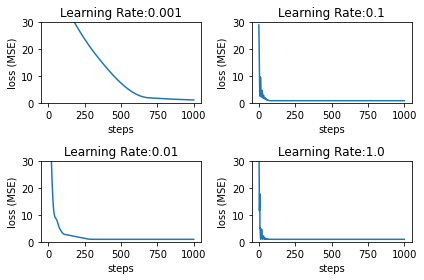

In [17]:
model.train(Adam)